In [17]:
import pandas as pd
import numpy as np
import joblib
# import matplotlib.pyplot as plt

# plt.style.use('ggplot')

In [ ]:
!pip install plotly

In [23]:
customers = joblib.load('data/customers_clean.pkl')
checkouts = joblib.load('data/checkouts_clean.pkl')
books = joblib.load('data/books_clean.pkl')
libraries = joblib.load('data/libraries_clean.pkl')

In [24]:
return_deadline = 28

checkouts['days_return'] = (checkouts['date_returned']-checkouts['date_checkout']).dt.days

## Late Return Aggregated Analysis
---

* Starting analysis is done on data from all libraries and all customer groups

In [26]:
print(f"Late returns total: {100*len(checkouts[checkouts['days_return']>return_deadline])/len(checkouts):.2f}%")

Late returns total: 6.91%


array([[<Axes: title={'center': 'days_return'}>]], dtype=object)

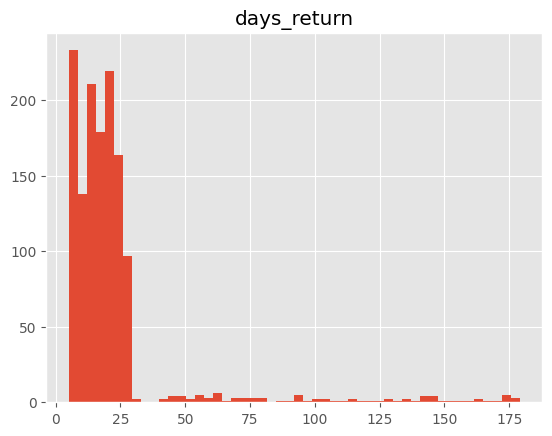

In [27]:
checkouts.hist('days_return', bins=50)